In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt

import pyvisa
from pylabnet.utils.logging.logger import LogClient
from pyvisa import VisaIOError, ResourceManager

from pylabnet.hardware.oscilloscopes.tektronix_tds2004C import Driver


# Connect to Log Server

In [2]:
# Instantiate
logger = LogClient(
    host='192.168.1.2',
    port=2902,
    module_tag='Scope'
)

# Connect to Tetronix TDS 2004C

The scope is connected via USB to the PC. 

In [3]:
# List all connected VISA ressources 
rm = pyvisa.ResourceManager()
rm.list_resources()

('USB0::0x0699::0x03A2::C013186::INSTR', 'ASRL3::INSTR', 'GPIB0::18::INSTR')

In [4]:
# Choose ID corresponding to the scope
gpib_address = 'USB0::0x0699::0x03A2::C013186::INSTR'

In [5]:
scope = Driver(
    gpib_address=gpib_address,
    logger=logger
)

In [6]:
# Find out which trigger source is set.
scope.get_trigger_source()

'CH1'

In [7]:
# Set trigger source to CH4
scope.set_trigger_source('CH4')
scope.get_trigger_source()

'CH4'

In [8]:
# Now let's check the timing scale
timing_scale = scope.get_timing_scale()
timing_scale

0.0005

In [9]:
# Let's decrease it by a factor of 1000
scope.set_timing_scale(timing_scale/1000)
scope.get_timing_scale()

5e-07

In [10]:
# Setup scope in single shot mode
scope.set_single_run_acq()

In [11]:
# Run one acquisition
scope.acquire_single_run()

In [12]:
# Read out trace
trace_dict = scope.read_out_trace('CH1')

In [ ]:
# Plot trace
scope.plot_traces(['CH1', 'CH2', 'CH4', 'CH3'], staggered=False)

In [ ]:
scope.device.query('CUR?')

In [20]:
scope.device.write('DATa:WIDth 2')

(14, <StatusCode.success: 0>)

In [68]:
scope.device.query('WFMPre?')

':WFMPRE:BYT_NR 2;BIT_NR 16;ENCDG ASC;BN_FMT RP;BYT_OR MSB;NR_PT 2500;WFID "Ch1, DC coupling, 1.0E0 V/div, 5.0E-7 s/div, 2500 points, Sample mode";PT_FMT Y;XINCR 2.0E-9;PT_OFF 0;XZERO -3.2E-7;XUNIT "s";YMULT 1.5625E-4;YZERO 0.0E0;YOFF 2.56E2;YUNIT "Volts"\n'

In [29]:
scope.device.write('SELect:CH3 1')

(14, <StatusCode.success: 0>)

In [13]:
wave_pre_regex = 'NR_PT (?P<n_points>[0-9\.\+Ee-]+).+\
        XINCR (?P<x_incr>[0-9\.\+Ee-]+).+\
        PT_OFF (?P<pt_off>[0-9\.\+Ee-]+).+\
        XZERO (?P<x_zero>[0-9\.\+Ee-]+).+\
        XUNIT "(?P<x_unit>[^"]+).+\
        YMULT (?P<y_mult>[0-9\.\+Ee-]+).+\
        YZERO (?P<y_zero>[0-9\.\+Ee-]+).+\
        YOFF (?P<y_off>[0-9\.\+Ee-]+).\
        YUNIT "(?P<y_unit>[^"]+)'

In [14]:
wave_pre = scope.device.query('WFMPre?')

In [15]:
import re
wave_pre_matches = re.search(wave_pre_regex, wave_pre)

In [16]:
int(wave_pre_matches['n_points'])

TypeError: 'NoneType' object is not subscriptable

In [89]:
trace = (trace - float(wave_pre_matches['y_off'])) * float(wave_pre_matches['y_mult']) + float(wave_pre_matches['y_zero'])
ts = float(wave_pre_matches['x_zero']) + (np.arange(int(wave_pre_matches['n_points'])) - int(wave_pre_matches['pt_off'])) * float(wave_pre_matches['x_incr'])

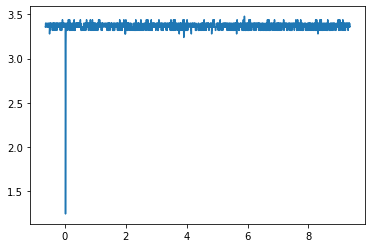

In [90]:
plt.plot(ts/500e-9, trace)

In [ ]:
search